In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell


### Navier stokes equation

We now turn to the one-dimensional compressional Navier-Stokes equation
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} (un ) + \nu_n\frac{\partial^2}{\partial x^2} n \\
     \frac{\partial }{\partial t} nu&= - \frac{\partial}{\partial x} nu^2 - \alpha\frac{\partial}{\partial x} n^\gamma + \nu_u\frac{\partial^2}{\partial x^2} u
 \end{align}
 
 For $\gamma=1$ and $\alpha=\tau$ these are the equations for an ideal gas in 1d,
 while for $\gamma=2$ and $\alpha=0.5g$ we get the shallow water equations.
 
 A numerically particularly challenging initial condition is the Riemann problem
 \begin{align}
 n(x,0) = \begin{cases} n_l \text{ for } x < x_a \\
 n_r \text{ else}
 \end{cases} \\
 u(x,0) = \begin{cases} u_l \text{ for } x < x_a \\
u_r \text{ else}
\end{cases}
 \end{align}
 For $\gamma=1$ this leads to Sod's shock tube problem while for $\gamma=2$ and $u_l = u_r = 0$ we have 
 a dam break over a dry/wet bed. Both these cases are widely discussed in the literature and have
 analytical solutions {cite}`Delestre2013` for the shallow water case.
 
 We intend to study various schemes to discretize these equations. We will start with the usual naive finite difference approximations on a **collocated grid**, where both density and velocity are discretized on the same cell-centres.
 We either use centered
 differences for all derivatives or an upwind scheme for the advection term in the continuity equation and Burger's term (keeping centered differences for the
wave terms $-n\partial_x u$ and $-\alpha \partial_x n^\gamma$). These are the schemes that we used for our Feltor simulations in the past.
 
A more robust approach is to use a so-called **staggered grid** discretization. This is a finite-volume type scheme and the 
basic idea is to shift the velocity grid by half a grid-point
such that the density is given on cell-centres while the velocity
is given on the faces.
Of the staggered discretizations, a particularly robust one seems
to be the one presented in {cite}`Herbin2013` and the PhD thesis of {cite}`Gunawan2015` where favourable qualities are shown:
- it is **positivity preserving**
- it is shown to satisfy an **entropy inequality**
- it is **shock-capturing**
- mass and energy conserving

The defining features of the scheme is that the pressure term $\alpha\partial_x n^\gamma$ in the momentum equation is discretized
implicitly and that the momenum form is discretized instead of the velocity formulation. This makes the scheme **semi-implicit**, however the
implicit equation can be trivially solved since the density and momentum equations decouple.

We study various variations of the scheme including taking the pressure term explicitly and discretizing the velocity form.
\begin{align}
     \frac{\partial }{\partial t} u&= - \frac{\partial}{\partial x} \frac{u^2}{2} - \alpha n^{-1}\frac{\partial}{\partial x} n^\gamma + \nu_un^{-1}\frac{\partial^2}{\partial x^2} u
\end{align}
There
is also a 2nd order formulation using a **slope-limiter** proposed in {cite}`Gunawan2015`, which however might be closer to a flux-limter in fact.

The energy theorem of the above equations reads
\begin{align}
\frac{\partial }{\partial t} \left(f(n) + \frac{1}{2}nu^2\right)+ \partial_x \left( f'(n) nu +\frac{1}{2}nu^3\right) = \nu_n \partial_x^2 n \left(f'(n) + \frac{1}{2}u^2\right) + u \nu_u \partial_x^2 u
\end{align}
with
\begin{align}
f(n) = \alpha\begin{cases}
   n(\ln n-1) \text{ for } \gamma = 1 \\
    \frac{1}{\gamma - 1} n^\gamma \text{ else}
    \end{cases}
\end{align}


In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
# The code navier_stokes.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_navier_stokes_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
    },
#     "init":
#     {
#         # A sine wave in density and velocity
#         "type" : "wave",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         # Analytical solution only for gamma : 1
#     },
    "init":
    {
        "type" : "step", # same as riemann with 0 velocity
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 0.2, # density right of jump
    },
#     "riemann":
#     {
#         "type" : "riemann",
#         "x_a" : 0.5, # location of jump
#         "n_l" : 1,   # density left of jump
#         "n_r" : 10, # density right of jump
#         "u_l" : 5,   # density left of jump
#         "u_r" : 7.5, # density right of jump
#     },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         "v" : 1 # velocity of mms solution
#         # Analytical solution only for gamma : 1
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # upwind
        # upwind2
        # centered
        # staggered (allows variant)
        # velocity-staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take pressure term explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and pressure term explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "nu_u" : 0.0, # viscosity
        "nu_n" : 0.0, # diffusivity (can be used to stabilize)
#         "gamma" : 1,
#         "alpha" : 1 
        # Shallow water equations:
        "gamma" : 2, 
        "alpha" : 9.81/2.0  # half the gravity
    },
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU"
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.025, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [3]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./navier_stokes","temp.json", "temp.nc")
rep.clean()
rep.run( make_navier_stokes_input(), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the RHS functor (including failed steps)
density (21, 32) 	Numerical density
velocity (21, 32) 	Numerical velocity
density_ana (21, 32) 	Analytical solution to the density
velocity_ana (21, 32) 	Analytical solution to the velocity


In [4]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_navier_stokes( p_list, plot = "fields", save_fig = False, figure_name = "test.png"):
    frows = 1
    fcols = 2
    plt.rcParams.update({'font.size': 18})

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        nsteps = var["nsteps"][last_idx]
        nfailed = var["failed"][last_idx]
        error_n = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana_n = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        error_u = var["velocity"][:,:] - var["velocity_ana"][:,:]
        norm_ana_u = np.linalg.norm( var["velocity_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])

        x = var["x"][:]

        if not plotted and (norm_ana_n != 0 or norm_ana_u != 0) and plot == "fields":
            im = ax[0].plot(x, var["density_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            im = ax[1].plot(x, var["velocity_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            plotted = True
        l = f"{p['advection']['type']}"
        if( "variant" in p["advection"].keys() ):
            if (p['advection']['variant'] == "original") :
                l = l + " semi-implicit"
            else : 
                l = l + f" {p['advection']['variant']}"
        print(l)
        if norm_ana_n != 0 or norm_ana_u != 0:
            print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\
  {np.linalg.norm(error_u[last_idx,:], ord=1)/norm_ana_u:.2e}", end=" ")            
        print( f"\tFunction calls: {nsteps} Failed: {nfailed}")
        print(f"Nx = {p['grid']['Nx']}")
        if plot == "fields" : 
            im = ax[0].plot(x,var["density"][last_idx,:], p["ls"], label=l, lw=4)
            im = ax[1].plot(x,var["velocity"][last_idx,:], p["ls"], label=l, lw=4,)
        else :
            # Compute mass and energy
            mass = var["density"][:,:]
            energy = 0.5 * var["density"][:,:]*var["velocity"][:,:]**2
            if( p["physical"]["gamma"] == 1) :
                energy = energy + p["physical"]["alpha"] *var["density"][:,:]*(np.log( var["density"][:,:]) - 1)
            else :
                energy = energy + p["physical"]["alpha"]/(p["physical"]["gamma"]-1
                                                       ) *var["density"][:,:]**p["physical"]["gamma"]

            x = var["x"][:]
            total_mass = np.sum( mass[:,:], axis = 1)*(x[1]-x[0])
            total_energy = np.sum( energy[:,:], axis = 1)*(x[1]-x[0])
            im = ax[0].plot( var["time"][1:], ((total_mass[0] - total_mass[1:])/total_mass[0]), p["ls"], label=l, lw=4)
            im = ax[1].plot( var["time"][1:], np.abs((total_energy[0] - total_energy[1:])/total_energy[0]), p["ls"], label=l, lw=4)
        
        
        ncin.close()
    if plot == "fields":
        ax[0].set_title( f"density")
        ax[0].set_xlabel( r"x")
        ax[1].set_title( f"velocity")
        ax[1].set_xlabel( r"x")
    else:
        ax[0].set_title( f"Mass conservation")
        ax[0].set_xlabel( r"t")
        ax[1].set_title( f"Energy conservation")
        ax[1].set_xlabel( r"t")
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
#         ax[0].set_yscale('log')
        ax[1].set_yscale('log')
    ax[0].grid(True)
    ax[1].grid(True)
    #         ax[0].set_ylabel("n")
    ax[0].legend()
#         ax[1].set_ylabel("u")
    if save_fig :
        plt.savefig( figure_name, bbox_inches="tight")

As a first example we study the dam break over a dry bed without viscosity

staggered semi-implicit
	L2 Error norm is 3.43e-03  1.19e-02 	Function calls: 4790.0 Failed: 0.0
Nx = 500
staggered slope-limiter
	L2 Error norm is 9.80e-04  4.96e-03 	Function calls: 5776.0 Failed: 6.0
Nx = 500
staggered semi-implicit
	L2 Error norm is 3.43e-03  1.19e-02 	Function calls: 4790.0 Failed: 0.0
Nx = 500
staggered slope-limiter
	L2 Error norm is 9.80e-04  4.96e-03 	Function calls: 5776.0 Failed: 6.0
Nx = 500


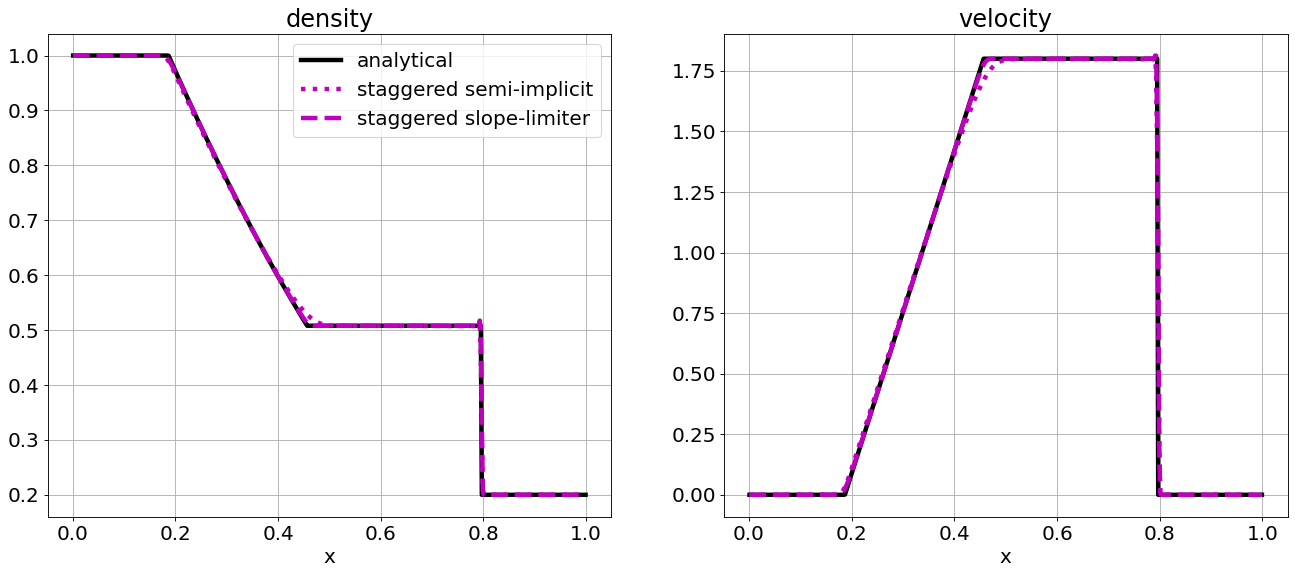

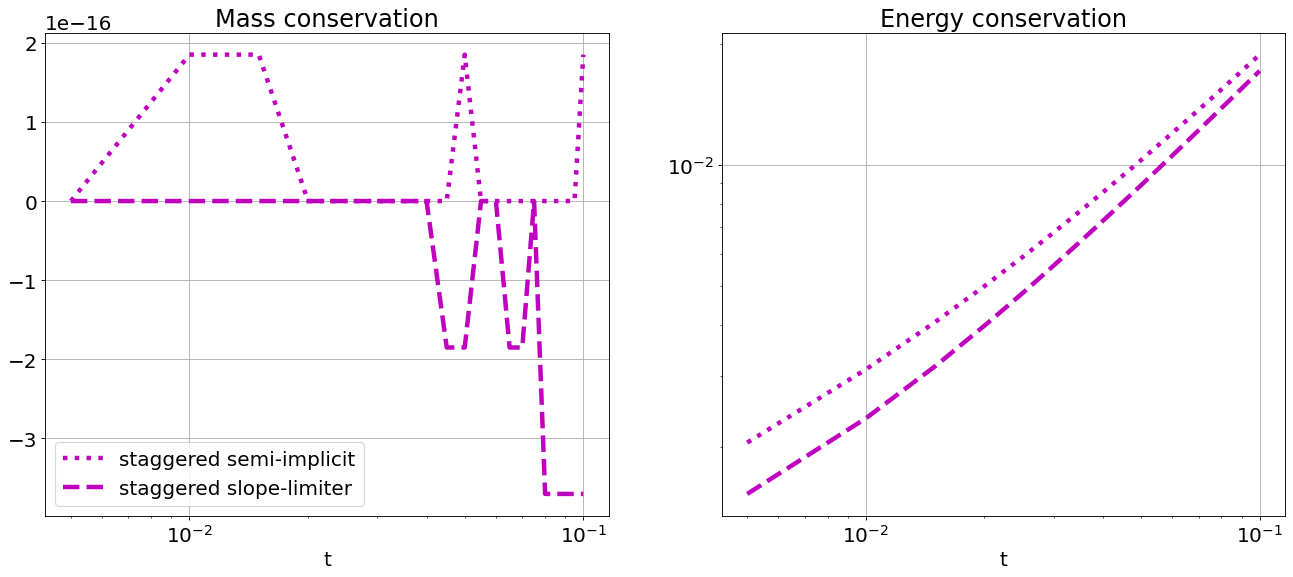

In [5]:
p_list = []
for p in [
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b--"},
    {"type" : "staggered", "variant" : "original", "ls" : "m:"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "m--"},
        ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 500
    params["ls"]= p["ls"]
    params["output"]["tend"] = 0.1
#     params["physical"]["nu_u"] = 0.01
    #params["physical"]["gamma"] = 1
    #params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot = "fields")
plot_navier_stokes(p_list, plot = "energy")

- the original schemes of 1st and 2nd order converge to the correct solution as advertised

Next, we try to solve Burger's equation

velocity-staggered explicit
	L2 Error norm is inf  9.69e-04 	Function calls: 1738.0 Failed: 0.0
Nx = 1000


/tmp/ipykernel_15354/1560052751.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\


velocity-staggered slope-limiter-explicit
	L2 Error norm is inf  8.16e-04 	Function calls: 2427.0 Failed: 33.0
Nx = 1000


/tmp/ipykernel_15354/1560052751.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\


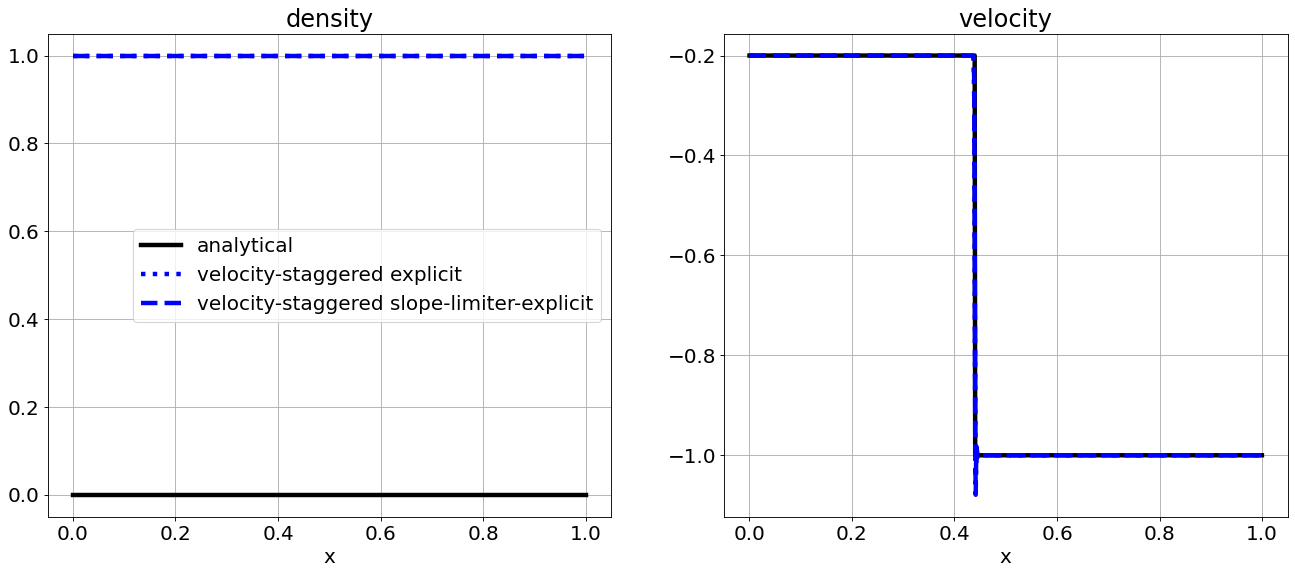

In [6]:
p_list = []
for p in [
#     {"type" : "staggered", "variant" : "original", "ls" : "g:"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g--"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
#     {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "upwind", "ls" : "r--"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] = 0.1
    params["ls"] = p["ls"]
    params["init"] ={
        "type" : "riemann",
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 1,  # density right of jump
        "u_l" : -0.2,   # density left of jump
        "u_r" : -1, # density right of jump
    }
    params["physical"]["alpha"] = 0
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

staggered semi-implicit
	L2 Error norm is 7.08e-03  2.55e-02 	Function calls: 2354.0 Failed: 0.0
Nx = 200
staggered slope-limiter
	L2 Error norm is 2.39e-03  1.21e-02 	Function calls: 2873.0 Failed: 11.0
Nx = 200
staggered explicit
	L2 Error norm is 7.08e-03  2.55e-02 	Function calls: 2712.0 Failed: 1.0
Nx = 200
staggered slope-limiter-explicit
	L2 Error norm is 2.39e-03  1.21e-02 	Function calls: 3897.0 Failed: 124.0
Nx = 200
velocity-staggered semi-implicit
	L2 Error norm is 1.97e-02  6.25e-02 	Function calls: 3182.0 Failed: 0.0
Nx = 200
velocity-staggered explicit
	L2 Error norm is 1.97e-02  6.25e-02 	Function calls: 3375.0 Failed: 1.0
Nx = 200
velocity-staggered slope-limiter-explicit
	L2 Error norm is 1.33e-02  4.47e-02 	Function calls: 4124.0 Failed: 63.0
Nx = 200
velocity-staggered slope-limiter
	L2 Error norm is 1.33e-02  4.47e-02 	Function calls: 3599.0 Failed: 1.0
Nx = 200
staggered-direct
	L2 Error norm is 1.10e-01  2.60e-01 	Function calls: 7289.0 Failed: 3.0
Nx = 200
upwin

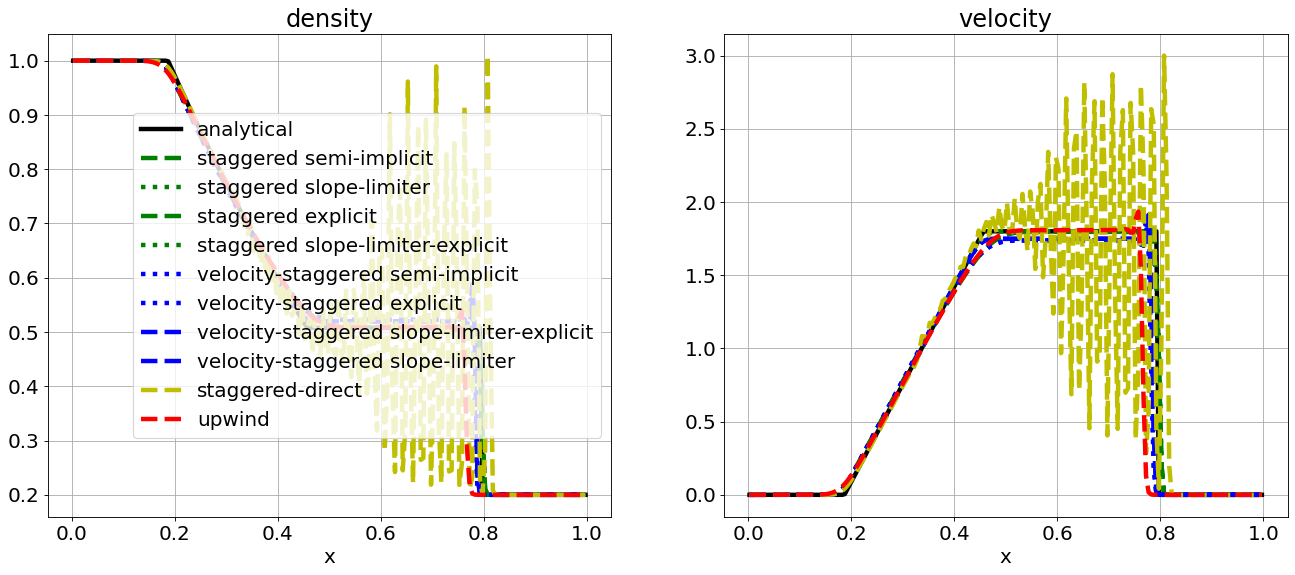

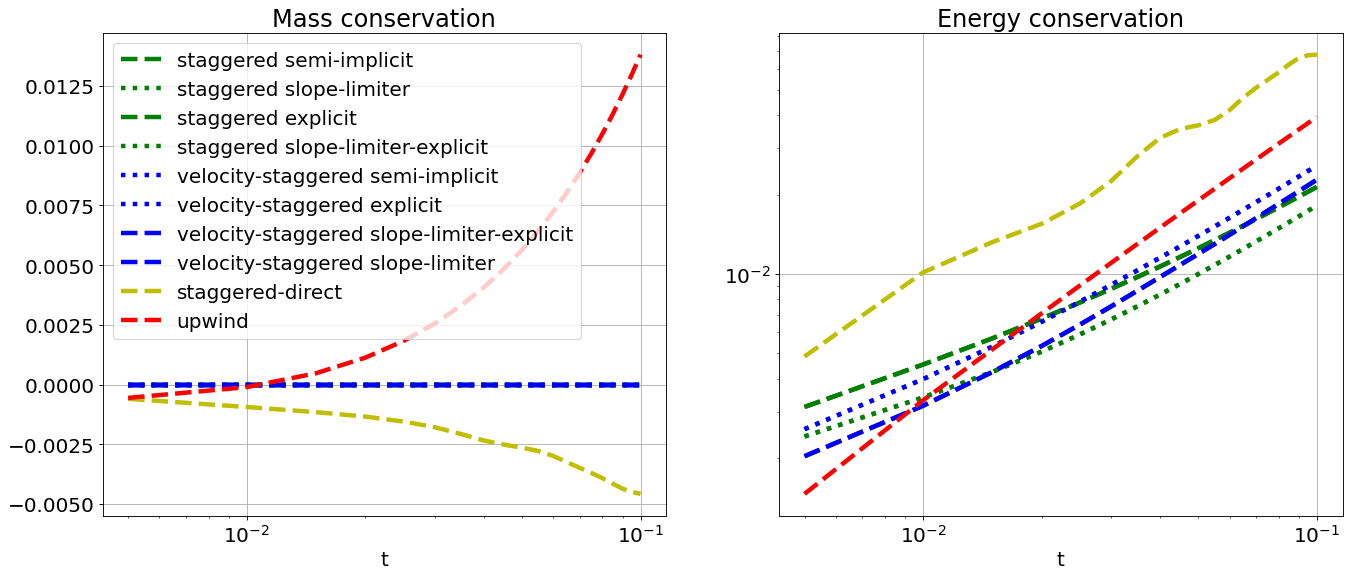

In [7]:
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
    {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#    {"type" : "velocity-unstaggered", "variant" : "explicit", "ls" : "k:"},
#    {"type" : "velocity-unstaggered", "variant" : "slope-limiter", "ls" : "k--"},
#     {"type" : "centered", "ls" : "m--"},    
    {"type" : "staggered-direct", "ls" : "y--"},
#    {"type" : "log-staggered", "ls" : "o:", "variant": "explicit"},
#    {"type" : "log-staggered", "ls" : "o--", "variant": "slope-limiter"},
   {"type" : "upwind", "ls" : "r--"},
#    {"type" : "upwind2", "ls" : "r:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 200
    params["output"]["tend"] = 0.1
    params["ls"] = p["ls"]
#     params["physical"]["nu_u"] = 1e-4
#     params["physical"]["gamma"] = 1
#     params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["type"] == "upwind" or p["type"] == "upwind2" 
       or p["type"] == "centered" or p["type"] == "staggered-direct"
       or p["type"] == "log-staggered"):
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    elif( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot="fields")
plot_navier_stokes(p_list, plot="energy")

We see that even with very high resolution
- the explicit staggered schemes converge to the correct solution as well contradicting the literature; we are unable to reproduce Figure 1.6 in Gunawan's thesis (even after trying to use fixed-step Euler scheme in order to exclude effects from the different timestepper we use)
- the upwind and velocity-staggered schemes both do not converge to the analytic solution

staggered explicit
	Function calls: 864.0 Failed: 1.0
Nx = 1000
staggered semi-implicit
	Function calls: 1110.0 Failed: 0.0
Nx = 1000


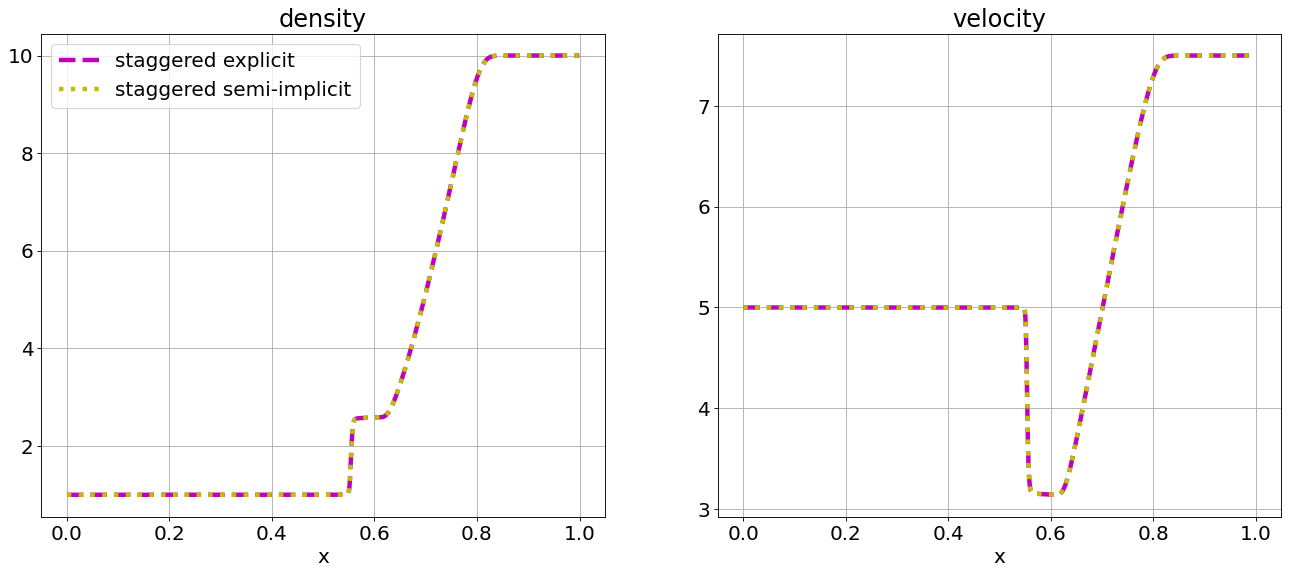

In [8]:
# Here, we try to reproduce the plot in Herbin that explicit schemes have a non-entropic solution
# (which we cannot)
p_list = []
for p in [
#     {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b--"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "m--"},
    {"type" : "staggered", "variant" : "original", "ls" : "y:"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls": "m:"},
#     {"type" : "upwind", "ls" : "r--"},
         ] :
    params = make_navier_stokes_input()
    params["ls"] = p["ls"]
    params["grid"]["Nx"]= 1000
    params["grid"] ["x"] = [0,1]
    params["init"] = {
        "type" : "riemann",
        "x_a" : 0.5,
        "n_l" : 1,
        "n_r" : 10,
        "u_l" : 5,
        "u_r" : 7.5
    }
    
    params["output"]["tend"] = 0.025
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
        params["timestepper"]["type"] = "ERK"
#         params["timestepper"]["tableau"]  = "Midpoint-2-2"
#         params["timestepper"]["dt"] = 1e-3/10;
#         params["timestepper"]["type"] = "RK"
    params["physical"] ["alpha"] = 1 # they choose p = rho^2 
    params["physical"] ["gamma"] = 2 # they choose p = rho^2 
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot = "fields", save_fig = True, figure_name = "herbin.png")

velocity-staggered explicit
	L2 Error norm is 5.97e-03  4.98e-02 	Function calls: 4635.0 Failed: 1.0
Nx = 1000
staggered explicit
	L2 Error norm is 2.20e-03  1.59e-02 	Function calls: 3609.0 Failed: 1.0
Nx = 1000
staggered semi-implicit
	L2 Error norm is 2.20e-03  1.59e-02 	Function calls: 3322.0 Failed: 0.0
Nx = 1000


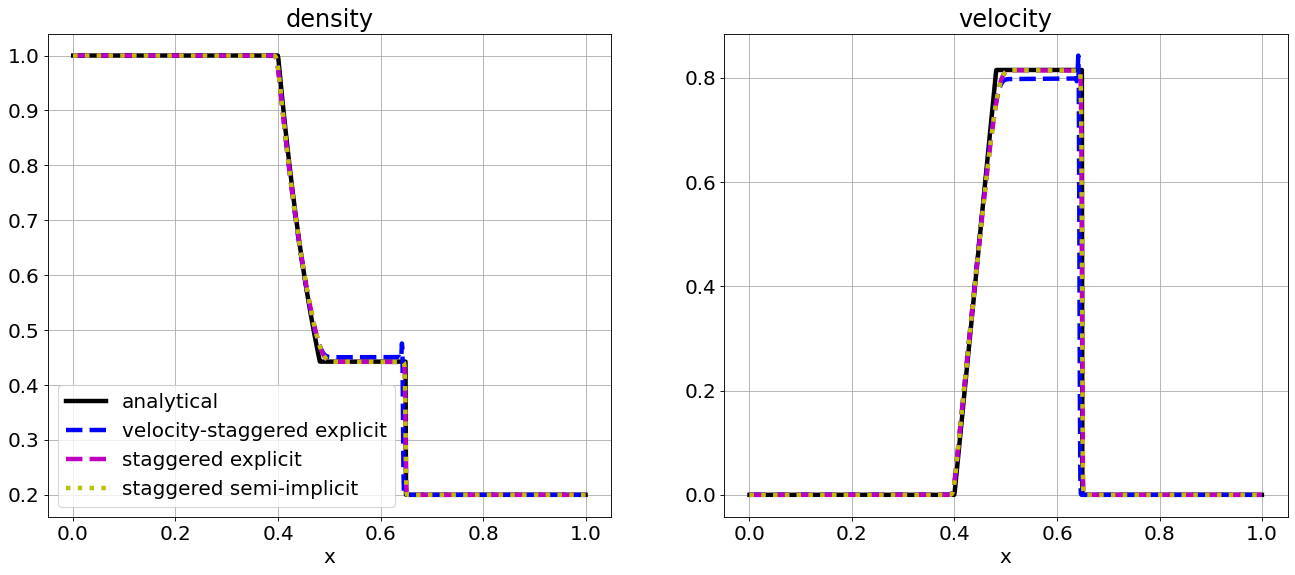

In [9]:
p_list = []
for p in [
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b--"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "m--"},
    {"type" : "staggered", "variant" : "original", "ls" : "y:"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls": "m:"},
#     {"type" : "upwind", "ls" : "r--"},
         ] :
    params = make_navier_stokes_input()
    params["ls"] = p["ls"]
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] = 0.1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
        params["timestepper"]["type"] = "ERK"
#         params["timestepper"]["tableau"]  = "Midpoint-2-2"
#         params["timestepper"]["dt"] = 1e-3/10;
#         params["timestepper"]["type"] = "RK"
    params["physical"] ["alpha"] = 1 # they choose p = rho^2 
    params["physical"] ["gamma"] = 1 # they choose p = rho^2 
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot = "fields", save_fig = True, figure_name = "sod.png")

Now we initialize a plane wave in the density and zero velocity. We observe the formation of shocks. Due to Burger's term the wave crest travels faster than the valley. We investigate the addition of a small viscosity.
Since we do not have an analytical solution we treat a high resolution staggered scheme as the true solution:

staggered slope-limiter
	Function calls: 13123.0 Failed: 417.0
Nx = 1000
staggered explicit
	Function calls: 1935.0 Failed: 1.0
Nx = 100
velocity-staggered explicit
	Function calls: 1977.0 Failed: 1.0
Nx = 100
velocity-staggered slope-limiter-explicit
	Function calls: 3651.0 Failed: 1.0
Nx = 100


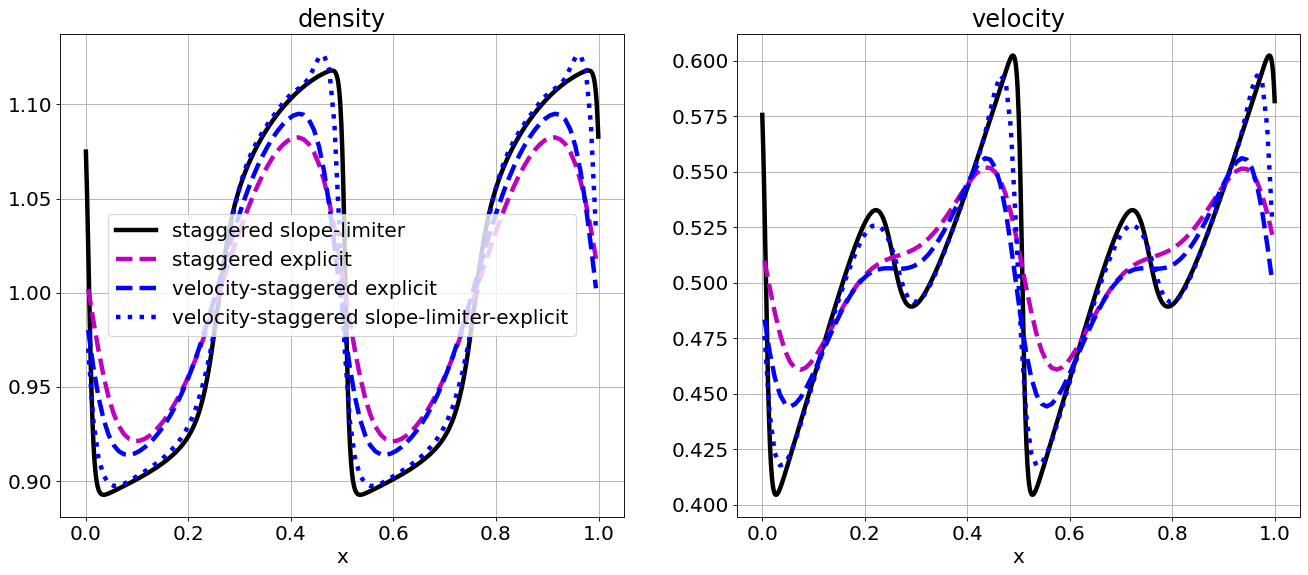

In [10]:
p_list = []
for p in [
    {"type" : "high_res", "ls" : "k-"},
#     {"type" : "staggered", "variant" : "original", "ls" : "g--"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "m--"},
#     {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b:"},
#     {"type" : "velocity-unstaggered", "variant" : "explicit", "ls" : "k:"},
#     {"type" : "velocity-unstaggered", "variant" : "slope-limiter", "ls" : "k--"},
#     {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "centered", "ls" : "m:"},
#     {"type" : "staggered-direct", "ls" : "m:"},
#     {"type" : "log-staggered", "ls" : "o--", "variant" : "explicit"},
#     {"type" : "log-staggered", "ls" : "o:", "variant" : "slope-limiter"},
#     {"type" : "upwind", "ls" : "r--"},
#     {"type" : "upwind2", "ls" : "r:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 100
    params["ls"] = p["ls"]
    if( p["type"] == "high_res") :
        params["grid"]["Nx"] = 1000
        p["type"] = "staggered"
        p["variant"] = "slope-limiter"
    params["init"] = {
        # A sine wave in density with 0 velocity
        "type" : "wave",
        "n_0" : 1.0,
        "u_0" : 0.5,
        "A" : 0.2,
        "B" : 0.1,
        "k" : 4*np.pi,
    }
    params["bc"] = {"density" : "PER", "velocity" : "PER"}
    params["physical"]["nu_n"] = 0
    params["physical"]["nu_u"] = 1e-3
    params["output"]["tend"] = 1.5
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["type"] == "upwind" or p["type"] == "upwind2" 
       or p["type"] == "centered" or p["type"] == "staggered-direct"
       or p["type"] == "log-staggered"):
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    elif( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["physical"] ["alpha"] = 1
    params["physical"] ["gamma"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot="fields", save_fig = True, figure_name = "wave-velocity")

staggered slope-limiter
	Function calls: 17394.0 Failed: 0.0
Nx = 100
staggered explicit
	Function calls: 7527.0 Failed: 127.0
Nx = 100
velocity-staggered explicit
	Function calls: 7521.0 Failed: 97.0
Nx = 100
velocity-staggered slope-limiter-explicit
	Function calls: 16377.0 Failed: 1.0
Nx = 100
staggered-direct
	Function calls: 29478.0 Failed: 1.0
Nx = 100


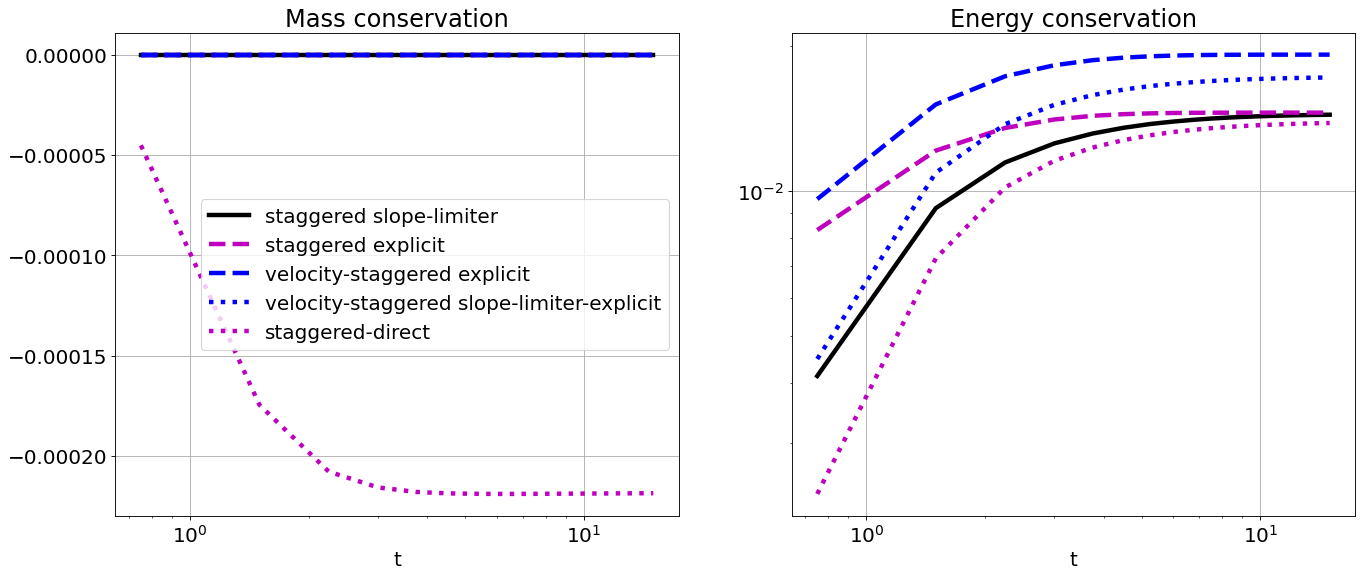

In [11]:
p_list = []
for p in [
    {"type" : "high_res", "ls" : "k-"},
#     {"type" : "staggered", "variant" : "original", "ls" : "g--"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "m--"},
#     {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b:"},
#     {"type" : "velocity-unstaggered", "variant" : "explicit", "ls" : "k:"},
#     {"type" : "velocity-unstaggered", "variant" : "slope-limiter", "ls" : "k--"},
#     {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "centered", "ls" : "m:"},
    {"type" : "staggered-direct", "ls" : "m:"},
#     {"type" : "log-staggered", "ls" : "o--", "variant" : "explicit"},
#     {"type" : "log-staggered", "ls" : "o:", "variant" : "slope-limiter"},
#     {"type" : "upwind", "ls" : "r--"},
#     {"type" : "upwind2", "ls" : "r:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 100
    params["ls"] = p["ls"]
    if( p["type"] == "high_res") :
        params["grid"]["Nx"] = 100
        p["type"] = "staggered"
        p["variant"] = "slope-limiter"
    params["init"] = {
        # A sine wave in density with 0 velocity
        "type" : "wave",
        "n_0" : 1.0,
        "u_0" : 0.5,
        "A" : 0.2,
        "B" : 0.1,
        "k" : 4*np.pi,
    }
    params["bc"] = {"density" : "PER", "velocity" : "PER"}
    params["physical"]["nu_n"] = 0
    params["physical"]["nu_u"] = 1e-3
    params["output"]["tend"] = 15
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["type"] == "upwind" or p["type"] == "upwind2" 
       or p["type"] == "centered" or p["type"] == "staggered-direct"
       or p["type"] == "log-staggered"):
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    elif( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["physical"] ["alpha"] = 1
    params["physical"] ["gamma"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list, plot="energy", save_fig = False)

We observe that
- shocks can form due to burgers term (the wave top moves faster than the wave bottom, steepening the front)
- surprisingly the collocated-upwind scheme is off by quite a bit for the low resolution ( but gets closer for higher resolution and higher viscosity)
- for very high resolution (Nx = 1000) all schemes coincide (not shown)
- if the viscosity is too small the centered scheme cannot compete (not shown in plot but it is far off)
- for the low resolution (Nx = 100) the velocity-staggered scheme seems qualitatively to behave as the staggered schemes, also in the entropy conservation, except for a slightly too large density
- surprisingly the explicit schemes need less function evaluations to achieve the solution. This is because even if the schemes need the same timestep the Bogacki-Shampine method has the fsal property and can thus save on function evaluations
- with the same ARK-4-2-3 tableau the explicit variants need slightly more timesteps than the implicit ones

In [12]:
# The mms method is to check that all terms are implemented correctly
# Maybe this should be presented in a nice table
p_list = []
for p in [
    {"type" : "staggered-direct"},
    {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "velocity-unstaggered", "variant" : "explicit"},
    {"type" : "velocity-unstaggered", "variant" : "slope-limiter"},
    {"type" : "upwind"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "log-staggered", "variant" : "slope-limiter"},
    {"type" : "upwind2"},
    {"type" : "centered"},
         ] :
    for Nx in [100,200,400,800,1600,3200]:
        params = make_navier_stokes_input()
        params["grid"]["Nx"]= Nx
        params["output"]["tend"] = 0.1
        params["init"] = {
             # Manufactured solution without shock
            "type" : "mms",
            "n_0" : 1,
            "u_0" : 0.5,
            "A" : 0.2,
            "B" : 0.1,
            "k" : 4*np.pi,
            "v" : 1
            # Analytical solution only for gamma : 1
        }
        params["bc"] = {"density":"PER", "velocity" : "PER"}
        params["physical"]["nu_u"] = 0.0
        params["physical"]["gamma"] = 1
        params["physical"]["alpha"] = 1
        params["timestepper"]["type"] = "ARK"
        params["timestepper"]["tableau"]  = "ARK-4-2-3"
        params["advection"] = p
        rep.clean()
        rep.run( params)
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        error_n = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana_n = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        error_u = var["velocity"][:,:] - var["velocity_ana"][:,:]
        norm_ana_u = np.linalg.norm( var["velocity_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])
        l = f"{params['advection']['type']}"
        if( "variant" in params["advection"].keys() ):
            l = l + f" {params['advection']['variant']}"
        print( f"{l} {Nx} {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n}\
\t{np.linalg.norm(error_u[last_idx,:], ord=1)/norm_ana_u}")
        ncin.close()

staggered-direct 100 0.0002388307440625171	0.00042481870208286655
staggered-direct 200 5.975036223236197e-05	0.00010643231560776734
staggered-direct 400 1.4944919553233905e-05	2.6681986432129933e-05
staggered-direct 800 3.936556674231651e-06	6.838222936541016e-06
staggered-direct 1600 1.2349698849610513e-06	1.870670494989457e-06
staggered-direct 3200 5.958039591655306e-07	6.765927115934267e-07
staggered original 100 0.004072537494849185	0.007608363271289097
staggered original 200 0.0020872048617326527	0.0036963254797883305
staggered original 400 0.0010567126455409712	0.0018188878663702613
staggered original 800 0.0005317607431000267	0.0009021901112436122
staggered original 1600 0.00026671373733051714	0.0004492356267886566
staggered original 3200 0.00013356517219667688	0.00022415328697678353
staggered slope-limiter-explicit 100 0.00044122017144187186	0.0009857594290522578
staggered slope-limiter-explicit 200 0.00011253335861351633	0.00024346002593400473
staggered slope-limiter-explicit 

<IPython.core.display.Javascript object>


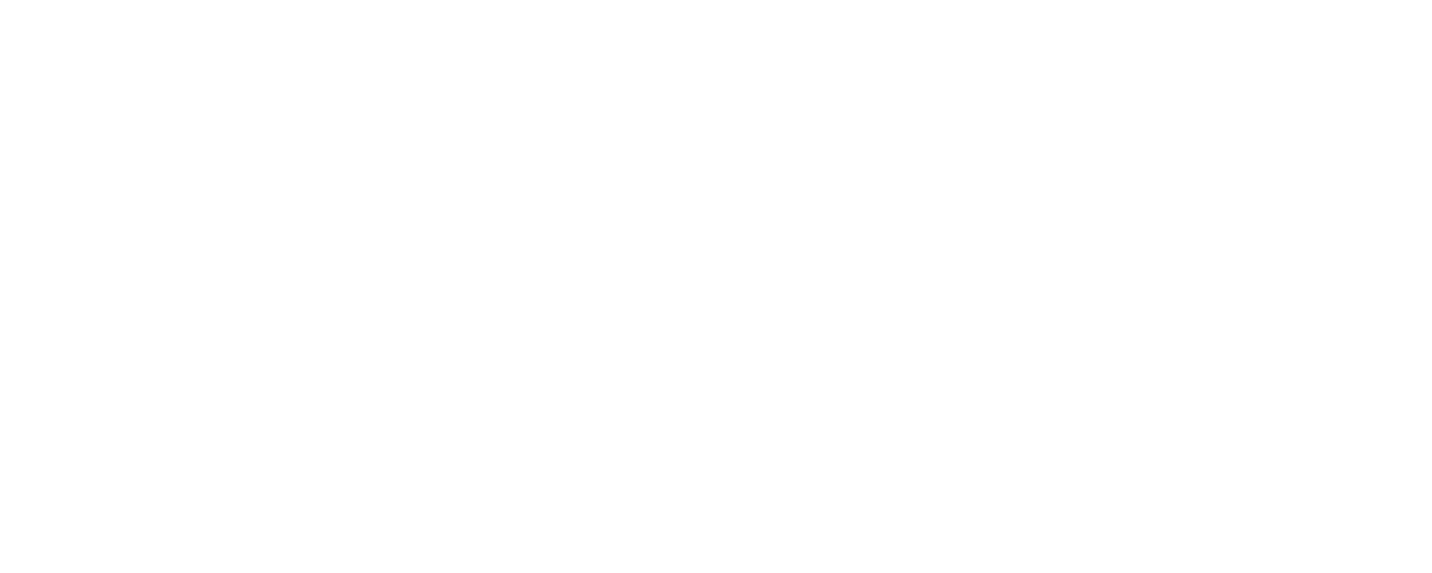

In [13]:
%matplotlib notebook
params = make_navier_stokes_input()
params["grid"]["Nx"]= 1000
params["grid"]["x"] = [0,5]

params["output"]["tend"] = 0.5

params["advection"] = {"type" : "staggered"}
params["output"]["maxout"] = 200
params["init"] ["x_a"] = 2.5
# Run simulation
rep.clean()
rep.run( params, error="display", stdout="ignore")


fcols = 2
frows = 1
fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')

ax[0].set_xlabel( "x")
ax[0].set_ylabel( "n")
ax[0].set_ylim(0,1.1)


ax[1].set_title( f"u(x,t)")
ax[1].set_xlabel( "x")
ax[1].set_ylabel( "u")
ax[1].set_ylim(0, 2.0)


ncin = Dataset( "temp.nc", 'r', format="NETCDF4")

x = ncin["x"][:]
time = ncin["time"][:]
ax[0].set_title( f"n(x,t) Nx = {params['grid']['Nx']} t = {time[0]:4.2f}")   


im0, = ax[0].plot( x, ncin["density"][0,:], lw=2)
im1, = ax[1].plot( x, ncin["velocity"][0,:], lw=2)

frames = params["output"]["maxout"]
def animate_fluid(iter):
    ax[0].set_title( f"n(x,t) Nx = {params['grid']['Nx']} t = {time[iter]:4.2f}") 
    im0.set_data (x, ncin["density"][iter,:])
    im1.set_data( x, ncin["velocity"][iter,:])
    return ax

ani = animation.FuncAnimation(fig,animate_fluid,frames=frames,interval=2,blit=True,repeat=True)
# plt.show()
writer = animation.writers['ffmpeg'](fps=50)

ani.save('breaking_dam_on_wet_bed.mp4',writer=writer,dpi=100)
ncin.close()

In [14]:
%matplotlib inline